In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# from IPython.display import Image, display
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

In [2]:
img_path = 'img_st/1.png'
# img_path = '/home/a/Documents/grad_cam/african_elephant.jpg'

model = tf.keras.models.load_model('es_func_folder_224x3_c.h5')
# # model = keras.applications.VGG16()
IMG_SIZE = (224, 224)

# model = keras.applications.EfficientNetB7()
# preprocess_input = keras.applications.efficientnet.preprocess_input
# IMG_SIZE = (600, 600)

# model = tf.keras.applications.MobileNetV2()
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# IMG_SIZE = (224,224)

In [3]:
last_conv_layer = next(
    x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D)
)

In [4]:
img = Image.open(img_path).resize(IMG_SIZE, Image.ANTIALIAS).convert('RGB')
img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)  # for pretrained
img = np.array(img)/255   # for MNIST

In [5]:
pred = model.predict(img)

In [6]:
# pred = np.argmax(pred)
pred = np.argmax(pred[0])

In [7]:
# model.summary()

In [8]:
# model.layers[-1].activation = None

In [9]:
grad_model = tf.keras.Model(
    [model.inputs], [last_conv_layer.output, model.output]
)

In [10]:
last_conv_layer.output.shape

TensorShape([None, 106, 106, 64])

In [11]:
model.output.shape

TensorShape([None, 10])

In [12]:
grad_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_12 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
activation_13 (Activation)   (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 108, 108, 64)      18496 

In [13]:
img.shape

(1, 224, 224, 3)

In [14]:
with tf.GradientTape() as tape:
    last_conv_out, prediction = grad_model(img)
    loss = prediction[:, pred]

In [44]:
type(pred)

numpy.int64

In [36]:
prediction.shape

TensorShape([1, 10])

In [15]:
loss.shape

TensorShape([1])

In [45]:
loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.99614906], dtype=float32)>

In [16]:
last_conv_out.shape

TensorShape([1, 106, 106, 64])

In [43]:
last_conv_out[0][0].numpy().max()

0.011007076

In [17]:
grads = tape.gradient(loss, last_conv_out)

In [18]:
grads.shape

TensorShape([1, 106, 106, 64])

In [19]:
[var.name for var in tape.watched_variables()]

['conv2d_8/kernel:0',
 'conv2d_8/bias:0',
 'conv2d_9/kernel:0',
 'conv2d_9/bias:0',
 'conv2d_10/kernel:0',
 'conv2d_10/bias:0',
 'conv2d_11/kernel:0',
 'conv2d_11/bias:0',
 'dense_4/kernel:0',
 'dense_4/bias:0',
 'dense_5/kernel:0',
 'dense_5/bias:0']

In [20]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

In [21]:
pooled_grads.shape

TensorShape([64])

In [22]:
last_conv_out = last_conv_out[0]

In [23]:
heatmap = last_conv_out @ pooled_grads[..., tf.newaxis]

In [24]:
last_conv_out.shape

TensorShape([106, 106, 64])

In [25]:
heatmap.shape

TensorShape([106, 106, 1])

In [26]:
heatmap = tf.squeeze(heatmap)

In [27]:
heatmap.shape

TensorShape([106, 106])

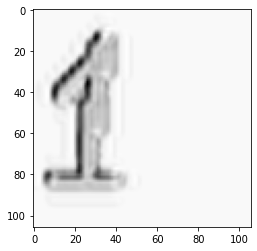

In [28]:
plt.imshow(heatmap, cmap='gray')

In [29]:
tf.maximum(heatmap, 0).shape

TensorShape([106, 106])

In [30]:
tf.math.reduce_max(heatmap).shape

TensorShape([])

In [31]:
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

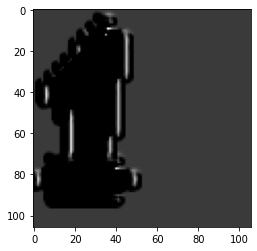

In [32]:
plt.imshow(heatmap.numpy(), cmap='gray')

In [33]:
last_conv_layer.name

'conv2d_11'